# Stock Price Predictions

We can also make testable predictions by restricting our model to a subset of the data, and then using the forecasted values to see how correct our model is. We will restrict data up until the end of 2016, and then try to make predictions for 2017.

In [1]:
# quandl for financial data, pandas and numpy for data manipulation
# prophet for additive models
import quandl 
import pandas as pd
import numpy as np
import fbprophet

# Plotting in the Jupyter Notebook
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting parameters
import matplotlib
inline_rc = dict(matplotlib.rcParams)
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 22
matplotlib.rcParams['text.color'] = 'k'



## Retrieve Data from Quandl

In [2]:
quandl.ApiConfig.api_key = 'rFsSehe51RLzREtYhLfo'

# Using Tesla data
tesla_stocks = quandl.get('WIKI/TSLA')

In [3]:
# Set the index (dates) to a column 
tesla_stocks.reset_index(level=0, inplace=True)

# Rename the columns for prophet and create a year column
tesla_stocks.rename(columns={'Date': 'ds', 'Adj. Close': 'y'}, inplace=True)
tesla_stocks['Year'] = [date.year for date in tesla_stocks['ds']]

In [6]:
# Training and testing data
tesla_train = tesla_stocks[tesla_stocks['Year'] < 2017]
tesla_test = tesla_stocks[tesla_stocks['Year'] > 2016]

## Prophet Model for Predicting Entire Year at Once

In [7]:
# Create a new model 
tesla_prophet = fbprophet.Prophet(changepoint_prior_scale=0.2)

# Train the model
tesla_prophet.fit(tesla_train)

# Number of days to make predictions 
days = (max(tesla_test['ds']) - min(tesla_test['ds'])).days

# Future dataframe
tesla_forecast = tesla_prophet.make_future_dataframe(periods = days, freq = 'D')

# Make forecasts
tesla_forecast = tesla_prophet.predict(tesla_forecast)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Accuracy and Profits (or losses) for Entire Year at Once

In [8]:
tesla_results = tesla_forecast.merge(tesla_test, how = 'inner', on = 'ds')
tesla_results = tesla_results[['ds', 'y', 'yhat']]

# Predicted difference between stock prices
tesla_results['pred_diff'] = (tesla_results['yhat']).diff()

# Actual difference between stock prices
tesla_results['real_diff'] = (tesla_results['y']).diff()

In [9]:
# Correct direction column
tesla_results['correct'] = (np.sign(tesla_results['pred_diff']) == np.sign(tesla_results['real_diff'])) * 1
print('Correct direction predicted: {:0.2f}% of days.'.format(100 * np.mean(tesla_results['correct'])))

Correct direction predicted: 48.24% of days.


## Value of Predictions

In [10]:
# Need to include the adjusted open to calculate profits or losses
tesla_results = tesla_results.merge(tesla_stocks[['ds', 'Adj. Open']], how = 'left', on = 'ds')
tesla_results['daily_change'] = abs(tesla_results['y'] - tesla_results['Adj. Open'])

In [11]:
# Only invest on days with predicted increase in stock price
tesla_pred_increase = tesla_results[tesla_results['pred_diff'] > 0]
tesla_pred_increase.reset_index(inplace=True)

profits = []

# If buy and stock goes up, add change to profits (1000 shares)
# If buy and stock goes down, subtract change from profit
for i, correct in enumerate(tesla_pred_increase['correct']):
    if correct == 1:
        profits.append(1000 * tesla_pred_increase.ix[i, 'daily_change'])
    else:
        profits.append(-1 * 1000 * tesla_pred_increase.ix[i, 'daily_change'])
        
tesla_pred_increase['profit'] = profits

In [12]:
print('Predicted profits for entire year at once: {:.0f} $.'.format(np.sum(tesla_pred_increase['profit'])))

Predicted profits for entire year at once: 24009 $.


In [13]:
smart_profit = 1000 * (tesla_results.ix[len(tesla_results) - 1, 'y'] - tesla_results.ix[0, 'Adj. Open'])
print('Buy and Hold for entire year profits: {:.0f} $.'.format(smart_profit))

Buy and Hold for entire year profits: 121550 $.


# Visualizations of Entire Year at Once

In [14]:
# Dataframe for plotting
tesla_plot = pd.merge(tesla_stocks, tesla_forecast, on = 'ds', how = 'inner')

## Predictions and Actual Values

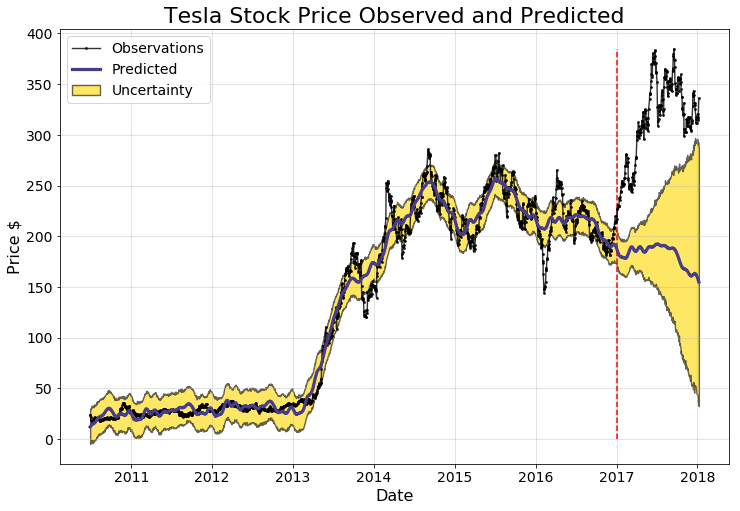

In [15]:
# Set up the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot the actual values
ax.plot(tesla_plot['ds'], tesla_plot['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
# Plot the predicted values
ax.plot(tesla_plot['ds'], tesla_plot['yhat'], 'darkslateblue',linewidth = 3.2, label = 'Predicted');

# Plot the uncertainty interval as ribbon
ax.fill_between(tesla_plot['ds'].dt.to_pydatetime(), tesla_plot['yhat_upper'], tesla_plot['yhat_lower'], alpha = 0.6, 
               facecolor = 'gold', edgecolor = 'k', linewidth = 1.4, label = 'Uncertainty')

# Put a vertical line at the start of predictions
plt.vlines(x='2017-01-01', ymin=0, ymax=max(tesla_plot['y']), colors = 'r',
           linestyles='dashed')

# Plot formatting
plt.legend(loc = 2, prop={'size': 14}); plt.xlabel('Date'); plt.ylabel('Price $');
plt.grid(linewidth=0.6, alpha = 0.6)
plt.title('Tesla Stock Price Observed and Predicted');

## Predicted and Smart Profits over Year 

In [16]:
# Merge results with the predicted increase containing profits
# tesla results contains actual data and predicted values
tesla_results = pd.merge(tesla_results, tesla_pred_increase[['ds', 'profit']], on = 'ds', how='left')

In [17]:
# Total predicted profit at each day
tesla_results['total_profit'] = tesla_results['profit'].cumsum()

In [18]:
# Forward fill the total predicted profits
tesla_results.ix[0, 'total_profit'] = 0
tesla_results['total_profit'] = tesla_results['total_profit'].ffill()

In [19]:
# Calculate the profits from buying and holding
smart_profits = []
first_open = tesla_results.ix[0, 'Adj. Open']

for i, close in enumerate(tesla_results['y']):
    smart_profits.append(1000 * (close - first_open))
   
# No need for cumulative sum because smart profits are unrealized
tesla_results['total_smart'] = smart_profits

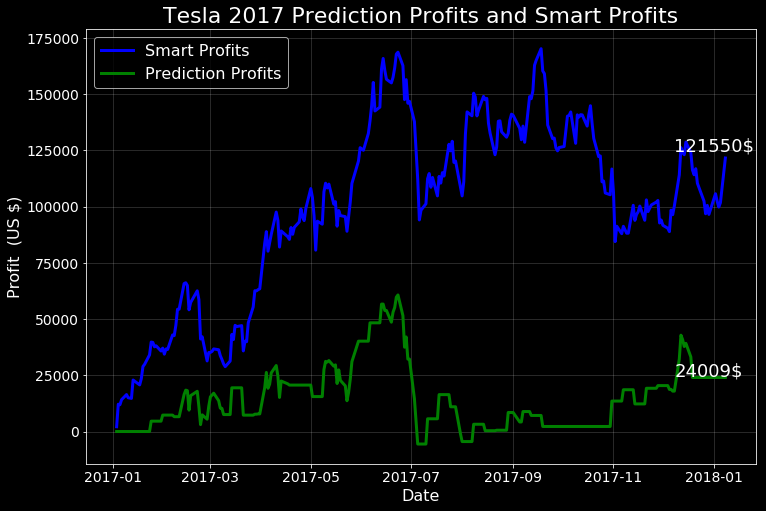

In [22]:
# Final profit and final smart used for locating text
final_profit = tesla_results.ix[len(tesla_results) - 1, 'total_profit']
final_smart = tesla_results.ix[len(tesla_results) - 1, 'total_smart']

# text location
last_date = tesla_results.ix[len(tesla_results) - 1, 'ds']
text_location = (last_date - pd.DateOffset(months = 1)).date()

plt.style.use('dark_background')
plt.figure(figsize=(12, 8))

# Plot smart profits
plt.plot(tesla_results['ds'], tesla_results['total_smart'], 'b',
         linewidth = 3, label = 'Smart Profits') 

# Plot prediction profits
plt.plot(tesla_results['ds'], tesla_results['total_profit'], 
         color = 'g' if final_profit > 0 else 'r',
         linewidth = 3, label = 'Prediction Profits')

# Display final values on graph
plt.text(x = text_location, 
         y =  final_profit + (final_profit / 40),
         s = '%d$' % final_profit,
        color = 'w' if final_profit > 0 else 'r',
        size = 18)
plt.text(x = text_location, 
         y =  final_smart + (final_smart / 40),
         s = '%d$' % final_smart,
        color = 'w' if final_smart > 0 else 'r',
        size = 18);

# Plot formatting
plt.ylabel('Profit  (US $)'); plt.xlabel('Date'); 
plt.title('Tesla 2017 Prediction Profits and Smart Profits');
plt.legend(loc = 2, prop={'size': 16});
plt.grid(alpha=0.2); 


### Plotting Lines Segments with Different Colors for Losses and Profits (Not Used)

This is really complicated code that I copied and pasted from the matplotlib documentation. It does work, but because I don't entirely understand it, I decided to go with the simpler graph.

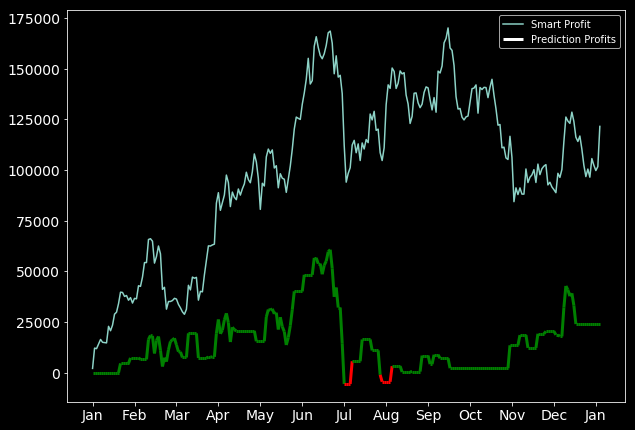

In [23]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


x = np.array(list(range(len(tesla_results))))
xlabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
           'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan']

y = np.array(tesla_results['total_profit'])

# Create a colormap for red, green and blue and a norm to color
# f' < -0.5 red, f' > 0.5 blue, and the rest green
cmap = ListedColormap(['r', 'g'])
norm = BoundaryNorm([0], cmap.N)

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be numlines x points per line x 2 (x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object, setting the colormapping parameters.
# Have to set the actual values used for colormapping separately.
lc = LineCollection(segments, label = 'Prediction Profits', cmap=cmap, norm=norm)
lc.set_array(y)
lc.set_linewidth(3)

xticks = list(range(0, x.max(), int(x.max() / 12)))

fig1 = plt.figure(figsize=(10,8))
fig1.autofmt_xdate()
plt.gca().add_collection(lc)
plt.plot(x, tesla_results['total_smart'], label = 'Smart Profit')
plt.xticks(xticks, xlabels);
plt.legend();

# Forecast the next month at Once

In [24]:
# Make new model and fit
forecast_prophet = fbprophet.Prophet(daily_seasonality=False,
                                     changepoint_prior_scale=0.3)
forecast_prophet.fit(tesla_stocks)

# Make future dataframe and predict
future_tesla = forecast_prophet.make_future_dataframe(periods=30, freq='D')
future_tesla = forecast_prophet.predict(future_tesla)

In [25]:
# Only want weekdays
weekdays = [i for i, date in enumerate(future_tesla['ds']) if date.dayofweek < 5]
future_tesla = future_tesla.ix[weekdays, :]

# Only predictions
future_tesla = future_tesla[future_tesla['ds'] > max(tesla_stocks['ds'])]

In [26]:
# Difference and buy/sell recommedation
future_tesla['diff'] = future_tesla['yhat'].diff()
future_tesla = future_tesla.dropna()
future_tesla['buy'] = [1 if diff > 0 else 0 for diff in future_tesla['diff']]

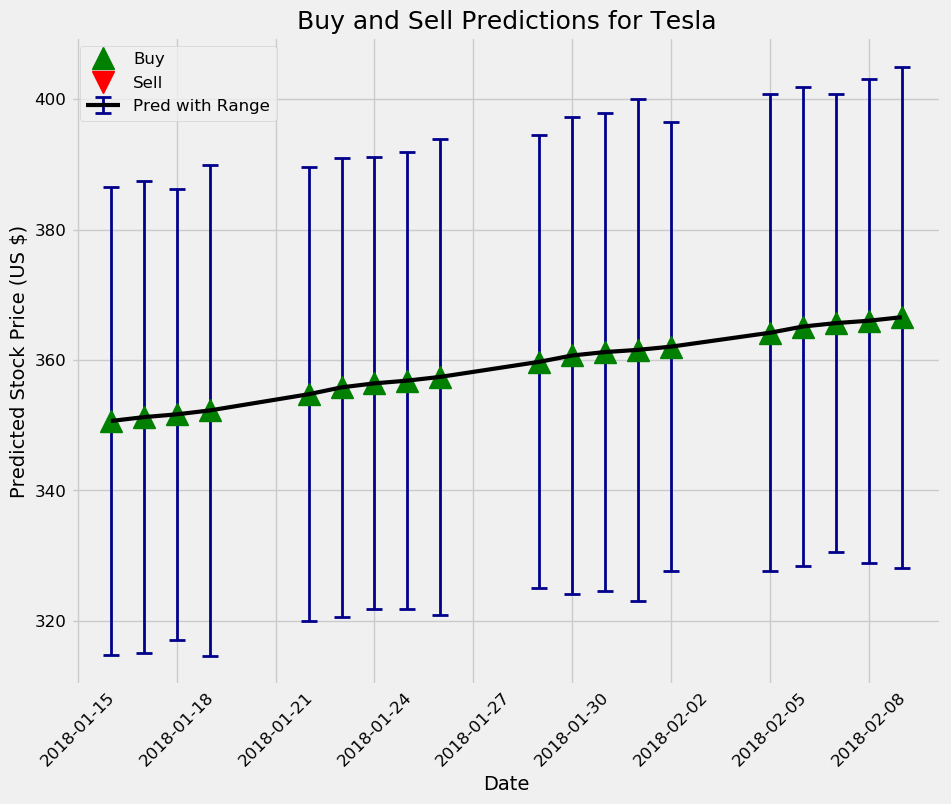

In [28]:
# Create two separate dataframes for plotting
future_buy = future_tesla[future_tesla['buy'] == 1]
future_sell = future_tesla[future_tesla['buy'] == 0]

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# Plot of future predictions
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['axes.titlesize'] = 18
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the estimates
ax.plot(future_buy['ds'], future_buy['yhat'], 'g^', ms = 16, label = 'Buy')
ax.plot(future_sell['ds'], future_sell['yhat'], 'rv', ms = 16, label = 'Sell')

# Plot errorbars
ax.errorbar(future_tesla['ds'].dt.to_pydatetime(), future_tesla['yhat'], 
            yerr = future_tesla['yhat_upper']- future_tesla['yhat_lower'], 
            capthick=2, color = 'k',linewidth = 3,
           ecolor='darkblue', capsize = 6, elinewidth = 2, label = 'Pred with Range')

# Plot formatting
plt.legend(loc = 2, prop={'size': 12});
plt.xticks(rotation = '45')
plt.ylabel('Predicted Stock Price (US $)');
plt.xlabel('Date'); plt.title('Buy and Sell Predictions for Tesla');

In [29]:
print('Recommeded Buy Dates:\n')
for date, change in zip(future_buy['ds'], future_buy['diff']):
    print('Date: {} \t Predicted Change: {:.2f}$.'.format(date.date(), change))

Recommeded Buy Dates:

Date: 2018-01-16 	 Predicted Change: 1.01$.
Date: 2018-01-17 	 Predicted Change: 0.59$.
Date: 2018-01-18 	 Predicted Change: 0.43$.
Date: 2018-01-19 	 Predicted Change: 0.60$.
Date: 2018-01-22 	 Predicted Change: 2.49$.
Date: 2018-01-23 	 Predicted Change: 1.06$.
Date: 2018-01-24 	 Predicted Change: 0.61$.
Date: 2018-01-25 	 Predicted Change: 0.42$.
Date: 2018-01-26 	 Predicted Change: 0.57$.
Date: 2018-01-29 	 Predicted Change: 2.31$.
Date: 2018-01-30 	 Predicted Change: 0.97$.
Date: 2018-01-31 	 Predicted Change: 0.53$.
Date: 2018-02-01 	 Predicted Change: 0.34$.
Date: 2018-02-02 	 Predicted Change: 0.49$.
Date: 2018-02-05 	 Predicted Change: 2.13$.
Date: 2018-02-06 	 Predicted Change: 0.95$.
Date: 2018-02-07 	 Predicted Change: 0.53$.
Date: 2018-02-08 	 Predicted Change: 0.36$.
Date: 2018-02-09 	 Predicted Change: 0.54$.


In [30]:
print('Recommended Sell Dates:\n')
for date, change in zip(future_sell['ds'], future_sell['diff']):
    print('Date: {} \t Predicted Change: {:.2f}$.'.format(date.date(), change))

Recommended Sell Dates:



# Evaluate on One Year One Day at a Time

In [55]:
stock = quandl.get('WIKI/TSLA')
stock.reset_index(level=0, inplace=True)

stock = stock.rename(columns={'Date': 'ds', 'Adj. Close': 'y'})

# Year column
stock['Year'] = [date.year for date in stock['ds']]

# Only going to use three years of past data 
stock = stock[stock['Year'] > 2013]

stock.head()

,ds,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,y,Adj. Volume,Year
884,2014-01-02,149.80,152.4769,146.550,150.10,6188400.0,0.0,1.0,149.80,152.4769,146.550,150.10,6188400.0,2014
885,2014-01-03,150.00,152.1900,148.601,149.56,4695000.0,0.0,1.0,150.00,152.1900,148.601,149.56,4695000.0,2014
886,2014-01-06,150.00,150.4000,145.240,147.00,5361100.0,0.0,1.0,150.00,150.4000,145.240,147.00,5361100.0,2014
887,2014-01-07,147.62,150.4000,145.250,149.36,5034100.0,0.0,1.0,147.62,150.4000,145.250,149.36,5034100.0,2014
888,2014-01-08,148.85,153.7000,148.760,151.28,6163200.0,0.0,1.0,148.85,153.7000,148.760,151.28,6163200.0,2014


We now need to iterate through every day from start of 2017 up until the end of the data, making a prediction one day at a time. We want to train our model on all the data up until the day we are predicting, and then predict only one day. This may take a little time, but we can speed things up if we do not make predictions for weekends. This will be a more realistic prediction than one year at a time, becuase if we were actively trading we would like to train a new model for every day.

In [81]:
# Make a dataframe to hold all the results
results = stock.copy()
results['yhat'] = 0
results['yhat_upper'] = 0
results['yhat_lower'] = 0

# Set the index for locating
results = results.set_index('ds')

In [88]:
day_range = pd.date_range(start=pd.datetime(2017, 1, 1), end=max(stock['ds']), freq='D')
eval_length = (day_range[-1] - day_range[0]).days

In [93]:
for i in range(10):
    print('\r', i, end='')

 9

In [ ]:
for i, day in enumerate(day_range):
    print('{:.2f}% Complete.\r'.format(100 * i / eval_length), end='')
    # Do not make predictions on Sat or Sun
    if day.weekday() == 5 or day.weekday() == 6:
        pass
        
    else:
        # Select all the training data up until prediction day
        train = stock[stock['ds'] < day.date()]
        # Create a prophet model and fit on the training data
        model = fbprophet.Prophet(daily_seasonality=False, changepoint_prior_scale=0.2)
        model.fit(train)
        
        # Make a future dataframe with one day
        future = model.make_future_dataframe(periods=1, freq='D')
        future = model.predict(future)
        
        # Extract the relevant prediction information
        yhat = future.ix[len(future) - 1, 'yhat']
        yhat_upper = future.ix[len(future) - 1, 'yhat_upper']
        yhat_lower = future.ix[len(future) - 1, 'yhat_lower']
        
        # Assign the dates to the results dataframe
        results.ix[day, 'yhat'] = yhat
        results.ix[day, 'yhat_upper'] = yhat_upper
        results.ix[day, 'yhat_lower'] = yhat_lower
    

In [ ]:
results_modify = results.copy()

In [78]:
results.reset_index(level=0, inplace=True)

# Columns of daily changes
results['pred_diff'] = results['yhat'].diff()
results['real_diff'] = results['y'].diff()

# Drop rows with na values 
# na values might occur on holidays 
results = results.dropna()

results.reset_index()

# Whether the prediction was right or wrong
# Multiply by 1 to convert to an integer
results['correct'] = (np.sign(results['pred_diff']) == np.sign(results['real_diff'])) * 1

# Calculate daily change in price
results['daily_change'] = abs(results['y'] - results['Adj. Open'])

# Only buy if predicted to increase
results_pred_increase = results[results['pred_diff'] > 0]

# Calculate profits or losses
profits = []
for i, correct in enumerate(results_pred_increase['correct']):
    if correct == 1:
        profits.append(1000 * results.ix[i, 'daily_change'])
    else:
        profits.append(-1 * 1000 * results.ix[i, 'daily_change'])

results_pred_increase['profit'] = profits

# Dataframe for plotting profits
results = pd.merge(results, results_pred_increase[['ds', 'profit']], on = 'ds', how = 'left')

ValueError: cannot insert level_0, already exists

In [ ]:
results[results['yhat'] != 0]

In [ ]:
def plot_predictions(stock_df, forecast_df, ticker='TSLA'):
    # merge the two dataframes
    stock_plot = pd.merge(stock_df, forecast_df, on = 'ds', how = 'inner')
    
    # Plot parameters
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    
    matplotlib.rcParams['axes.labelsize'] = 16
    matplotlib.rcParams['xtick.labelsize'] = 14
    matplotlib.rcParams['ytick.labelsize'] = 14
    matplotlib.rcParams['axes.titlesize'] = 22
    matplotlib.rcParams['text.color'] = 'k'

    # Set up the plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Plot the actual values
    ax.plot(stock_plot['ds'], stock_plot['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observed')
    ax.plot(stock_plot['ds'], stock_plot['yhat'], 'darkslateblue',linewidth = 3.2, label = 'Predicted');

    # Plot the uncertainty interval
    ax.fill_between(stock_plot['ds'].dt.to_pydatetime(), stock_plot['yhat_upper'], stock_plot['yhat_lower'], alpha = 0.6, 
                   facecolor = 'gold', edgecolor = 'k', linewidth = 1.4, label = 'Uncertainty')

    # Put a vertical line at the start of predictions
    plt.vlines(x='2017-01-01', ymin=0, ymax=max(stock_plot['y']), colors = 'r',
               linestyles='dashed')
    plt.legend(loc = 2, prop={'size': 14}); plt.xlabel('Date'); plt.ylabel('Price $');
    plt.grid(linewidth=0.6, alpha = 0.6)
    plt.title('%s Price Observed and Predicted' % ticker);

In [ ]:
def plot_profits(results, ticker):
    # Total predicted profit at each day
    results['total_profit'] = results['profit'].cumsum()
    
    # Forward fill the total predicted profits
    results.ix[0, 'total_profit'] = 0
    results['total_profit'] = results['total_profit'].ffill()
    
    # Calculate the profits from buying and holding
    smart_profits = []
    first_open = results.ix[0, 'Adj. Open']

    for i, close in enumerate(results['y']):
        smart_profits.append(1000 * (close - first_open))
    
    # Column with daily profits
    # No need for cumulative total because smart profits are unrealized
    results['total_smart'] = smart_profits
    
    # Final total profit and smart profit for plotting
    final_profit = results.ix[len(results) - 1, 'total_profit']
    final_smart = results.ix[len(results) - 1, 'total_smart']
    
    # Last date for location of text annotation
    last_date = results.ix[len(results) - 1, 'ds']
    text_location = (last_date - pd.DateOffset(months = 1)).date()

    # Plot parameters
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    matplotlib.rcParams['axes.labelsize'] = 16
    matplotlib.rcParams['xtick.labelsize'] = 14
    matplotlib.rcParams['ytick.labelsize'] = 14
    matplotlib.rcParams['axes.titlesize'] = 22
    matplotlib.rcParams['text.color'] = 'k'
    
    # Set the style
    plt.style.use('dark_background')
    
    # Set up the plot
    plt.figure(figsize=(10, 8))
    
    # Smart Profits
    plt.plot(results['ds'], results['total_smart'], 'b',
         linewidth = 3.0, label = 'Smart Profits') 
    
    # Prediction Profits
    plt.plot(results['ds'], results['total_profit'], 
         color = 'g' if final_profit > 0 else 'r',
         linewidth = 3.0, label = 'Prediction Profits')
    
    # Labels and Title
    plt.ylabel('Profit  (US $)'); plt.xlabel('Date'); 
    plt.title('%s 2017 Prediction Profits and Smart Profits' % ticker);
    
    # Legend and grid
    plt.legend(loc = 2, prop={'size': 16});
    plt.grid(alpha=0.6); 
    
    # Add label for final total profit
    plt.text(x = text_location, 
         y =  final_profit +  (final_profit / 40),
         s = '%d $' % final_profit,
        color = 'w' if final_profit > 0 else 'r',
        size = 16)
    # Add label for final smart profits
    plt.text(x = text_location, 
         y =  final_smart + (final_smart / 40),
         s = '%d $' % final_smart,
        color = 'w' if final_smart > 0 else 'r',
        size = 16);

In [ ]:
def forecast_and_plot(stock, changepoint_prior_scale=0.2):
    # Make new model and fit
    forecast_prophet = fbprophet.Prophet(daily_seasonality=False,
                                         changepoint_prior_scale=changepoint_prior_scale)
    forecast_prophet.fit(stock)

    # Make future dataframe and predict
    future = forecast_prophet.make_future_dataframe(periods=30, freq='D')
    future = forecast_prophet.predict(future)

    # Only want weekdays
    weekdays = [i for i, date in enumerate(future['ds']) if date.dayofweek < 5]
    future = future.ix[weekdays, :]

    # Only predictions
    future = future[future['ds'] >= max(stock['ds'])]
    
    # Difference between predictions
    future['diff'] = future['yhat'].diff()
    
    # Drop rows with na values
    future = future.dropna()
    
    # Buy/sell recommendation
    future['buy'] = [1 if diff > 0 else 0 for diff in future['diff']]

    # Create two separate dataframes for plotting
    future_buy = future[future['buy'] == 1]
    future_sell = future[future['buy'] == 0]

    # Plotting Parameters
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.style.use('fivethirtyeight')
    matplotlib.rcParams['axes.labelsize'] = 14
    matplotlib.rcParams['xtick.labelsize'] = 12
    matplotlib.rcParams['ytick.labelsize'] = 12
    matplotlib.rcParams['axes.titlesize'] = 18
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.plot(future_buy['ds'], future_buy['yhat'], 'g^', ms = 16, label = 'Buy')
    ax.plot(future_sell['ds'], future_sell['yhat'], 'rv', ms = 16, label = 'Sell')
    ax.errorbar(future['ds'].dt.to_pydatetime(), future['yhat'], 
            yerr = future['yhat_upper']- future['yhat_lower'], 
            capthick=2, color = 'k',linewidth = 3,
           ecolor='darkblue', capsize = 6, elinewidth = 2, label = 'Pred with Range')

    plt.legend(loc = 2, prop={'size': 12});
    plt.xticks(rotation = '45')
    plt.ylabel('Predicted Stock Price (US $)');
    plt.xlabel('Date'); plt.title('Buy and Sell Predictions for %s' % ticker);

    # Predicted buy dates
    print('Recommeded Buy Dates:\n')
    for date, change in zip(future_buy['ds'], future_buy['diff']):
        print('Date: {} \t Predicted Change: {:.2f}$.'.format(date.date(), change))
    
    # Predicted sell dates
    print('\nRecommended Sell Dates:\n')
    for date, change in zip(future_sell['ds'], future_sell['diff']):
        print('Date: {} \t Predicted Change: {:.2f}$.'.format(date.date(), change))
    
    print('\n')

In [ ]:
def stock_predictor(ticker='TSLA'):
    try:
        # Using years from 2011 onwards
        stock = quandl.get('WIKI/%s' % ticker.upper(), start_date = '2011-01-01')
    except Exception as e:
        print('Invalid Stock Ticker')
        print(e)
        return
    
    # Change the index to a Date column
    stock_clean = stock.reset_index()[['Date', 'Adj. Close', 'Adj. Open']]
    
    # Create a year column
    stock_clean['Year'] = [date.year for date in stock_clean['Date']]
    
    # Rename for prophet training
    stock_clean = stock_clean.rename(columns={'Date': 'ds', 'Adj. Close': 'y'})
    
    # Training and Testing Sets
    stock_train = stock_clean[stock_clean['Year'] < 2017]
    stock_test = stock_clean[stock_clean['Year'] > 2016]
    
    # Create the prophet model and fit on training set
    stock_prophet = fbprophet.Prophet(daily_seasonality=False,
                                      changepoint_prior_scale=0.2)
    stock_prophet.fit(stock_train)
    
    # Number of days to predict
    days = (max(stock_test['ds']) - min(stock_test['ds'])).days
    
    # Make forecasts for entire length of test set + one week
    stock_forecast = stock_prophet.make_future_dataframe(periods=days + 7, freq = 'D')
    stock_forecast = stock_prophet.predict(stock_forecast)
    
    # Plot the entire series
    plot_predictions(stock_clean, stock_forecast, ticker)
    
    # Dataframe for predictions and test values
    results = stock_forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']]
    
    # Merge to get acutal values (y)
    results = pd.merge(results, stock_test[['ds', 'y']], on = 'ds', how='right')
    
    # Merge to get daily opening values (Adj. Open)
    results = results.merge(stock_clean[['ds', 'Adj. Open']], on = 'ds', how ='inner')
    
    # Columns of daily changes
    results['pred_diff'] = results['yhat'].diff()
    results['real_diff'] = results['y'].diff()
    
    # Whether the prediction was right or wrong
    # Multiply by 1 to convert to an integer
    results['correct'] = (np.sign(results['pred_diff']) == np.sign(results['real_diff'])) * 1
    
    # Calculate daily change in price
    results['daily_change'] = abs(results['y'] - results['Adj. Open'])
    
    # Only buy if predicted to increase
    results_pred_increase = results[results['pred_diff'] > 0]
        
    # Calculate profits or losses
    profits = []
    for i, correct in enumerate(results_pred_increase['correct']):
        if correct == 1:
            profits.append(1000 * results.ix[i, 'daily_change'])
        else:
            profits.append(-1 * 1000 * results.ix[i, 'daily_change'])
    
    results_pred_increase['profit'] = profits
    
    # Dataframe for plotting profits
    results = pd.merge(results, results_pred_increase[['ds', 'profit']], on = 'ds', how = 'left')
    
    # Plot the profits (or losses)
    plot_profits(results, ticker)
    
    # Calculate total profit if buying 1000 shares every day
    total_profit = int(np.sum(profits))
    
    # Calculate total profit if buying and holding 1000 shares for entire time
    first_price = int(results[results['ds'] == min(results['ds'])]['y'])
    last_price = int(results[results['ds'] == max(results['ds'])]['y'])

    # Smart profit
    smart_profit = (last_price - first_price) * 1000
    
    # Total accuracy is percentage of correct predictions
    accuracy = np.mean(results['correct']) *  100
    
    performance = {'pred_profit': total_profit, 'smart_profit': smart_profit, 'accuracy': accuracy}
    
    print('You were correct {:.2f}% of the time.'.format(accuracy))
    print('Your profit from playing the stock market in {}: {:.0f} $.'.format(ticker, total_profit))
    print('The buy and hold profit (smart strategy) for {}: {:.0f} $.'.format(ticker, smart_profit))
    print('Thanks for playing the stock market!')
    
    return(stock_clean)

In [ ]:
stock = stock_predictor('TSLA')

In [ ]:
forecast_and_plot(stock, ticker = 'TSLA')

In [ ]:
stock = stock_predictor('CAT')

In [ ]:
stock = stock_predictor('MSFT')

In [ ]:
forecast_and_plot(stock, ticker = 'MSFT')